In [ ]:
# Homework 3 (due 07/16/2024)

# Eigenbears

## Instructions

#### Part 1: Data preparation (ALREADY COMPLETED)
The folder that contains this notebook also contains a data set of pictures of pandas and brown bears. 
1. Load the images for train and test.
2. Reduce their size/resolution by 50%.
3. Convert the colors to grey scale.
4. Display a few of the images. 

#### Part 2: Singular value decomposition (FOR YOU TO COMPLETE)
1. Follow the steps in the eigenfaces tutorial from the UW databook [[link]](https://github.com/dynamicslab/databook_python/blob/master/CH01/CH01_SEC06_2_3_4.ipynb) to perform an SVD on the images.
2. Note that you will need to "center the data" before doing the SVD. Data centering means replacing each variable $X_i$ with a new variable $X_i'$ that is equal to $X_i$ minus $X_i$'s mean value. (Think carefully about whether you want to use the mean of train set, test set, or the full data set for this.)
3. Display the first four "eigenbears" (i.e., the images associated with the first four eigenvectors). Explain what you see.
4. The singular vectors are sometimes called "principal components". Principal component analysis (PCA) is a data analysis method for which one projects high-dimensional data into the subspace of the first two singular vectors. Use the code scaffold provided below do perform PCA for the bears data. What do you notice?

#### Part 3: Non-parametric supervised classification (PARTIALLY FOR YOU TO COMPLETE)
1. Build a $k$-nearest-neighbors model with the train set, and test its accuracy on the test set. (ALREADY COMPLETE)
2. Try different values of $k$ between 1 and 15. For what value do you get the best test accuracy? (FOR YOU TO COMPLETE)
3. Which bears seem to be hard to classify? Display them.
4. What might make them hard to classify?

#### Part 4: Parametric supervised classification (PARTIALLY FOR YOU TO COMPLETE)
1. Try using logistic regression and LDA to classify the bears. 
2. What method gives you the best test accuracy? 
3. How does the result compare to the non-parametric classification?
4. One can use the absolute values of the regression coefficients to see which pixels have the greatest influence on the prediction of the logistic regression. Retrieving the coefficients $\beta_i$ for each pixel $X_i$ and displaying them as an image creates a "bear mask". This notebook includes code for creating that bear mask. Take a look at the bear mask and explain what you see.

#### Part 5: Robustness to additive white noise  (FOR YOU TO RUN AND COMMENT ON)
1. Rerun the code with `add_noise` set to True. The images of the bears should now be very noisy.
2. How does the additive noise affect the test accuracy of the various models and why?
3. How does additive noise affect the eigenbears and the bear mask?
4. Can you think of other types of noise that might affect the classification results differently?

--------------------------------

In [49]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import os, time

## Part 1: Data preparation

In [50]:
# toggle settings
add_noise = True

# Initiliaze lists for image collection
train_images = []
test_images = []

for i, images in enumerate([train_images, test_images]):

    # set paths to images of pandas and bears in train and test set
    datasetname = ['Train','Test'][i]
    folder_path1 = 'PandasBears/{}/Pandas/'.format(datasetname)
    folder_path2 = 'PandasBears/{}/Bears/'.format(datasetname)
    

    for folder_path in [folder_path1, folder_path2]:

        # print the name of the folder that is currently being processed
        print(folder_path, end=' ')
        
        # go through all files in the folder
        file_count = 0
        for filename in os.listdir(folder_path):
            
            # find the files that are JPEGs
            if filename.endswith(".jpg") or filename.endswith(".jpeg"):

                # add 1 to the file count
                file_count += 1
                
                # Construct full file path
                file_path = os.path.join(folder_path, filename)
    
                # import image
                image = plt.imread(file_path, format='jpeg')
    
                # convert to gray scale
                image = np.dot(image[...,:3], [0.2989, 0.5870, 0.1140])
    
                # decrease image size by 50%
                image = image[::2,::2]

                if add_noise:
                    # add some noise
                    image = image + np.random.normal(scale=100, size=image.shape)
    
                # add the new image to collection
                images.append(image)

        print('has {} images'.format(file_count))

PandasBears/Train/Pandas/ has 250 images
PandasBears/Train/Bears/ has 250 images
PandasBears/Test/Pandas/ has 50 images
PandasBears/Test/Bears/ has 50 images


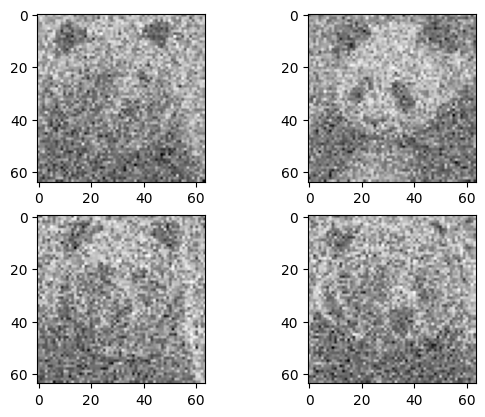

In [51]:
# look at 4 random bears
for i0, i in enumerate(np.random.randint(0, 500, size=4)):
    plt.subplot(2,2,1+i0)
    plt.imshow(train_images[i][::2,::2],cmap='Greys_r')

# Part 2: Singular value decomposition

In [52]:
# Construct data matrix of centered data
'''ADD SOME CODE HERE'''

train_images_flat = []

for image in train_images:
    flattened_image = image.flatten()
    train_images_flat.append(flattened_image)
# train_images_flat = [img.flatten() for img in train_images]
train_images_matrix = np.array(train_images_flat).T

# Compute the average face
avg_face = np.mean(train_images_matrix, axis=1)

# Mean-center the training images
X = train_images_matrix - avg_face[:, None]

# Perform SVD
U, S, Vh = np.linalg.svd(X)

# train_cols = []

# for image in train_images:
#     flat_image = np.array(image).flatten()
#     train_cols.append(flat_image)

# # Stack the flattened images as rows in a matrix
# train_mat = np.vstack(train_cols)

# print("train mat", train_mat.shape)

# # Compute the average image
# avg_image = np.mean(train_mat, axis=0, keepdims=True)

# print("avg image", avg_image.shape)

# # Subtract the average image from each image to get a mean-centered matrix
# X = train_mat - avg_image

# print("X", X.shape)
# -----------
# train_cols = []

# for image in train_images:
#     flat_image = np.array(image)
#     print(len(flat_image))
#     train_cols += [flat_image]
#     print("train cols", len(train_cols))

# train_mat = np.column_stack(train_cols)

# avg_image = np.mean(train_mat,axis = 1, keepdims=True)

# X = train_mat - avg_image

# # Perform SVD
# U, S, Vh = np.linalg.svd(X) # replace A with your centered data matrix

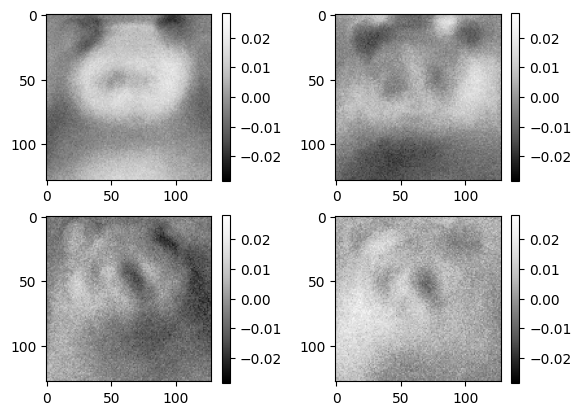

In [54]:
# show the first four eigenbears
for i in range(4):
    plt.subplot(2,2,1+i)
    plt.imshow((U[:,i]).reshape((128,128)), cmap='Greys_r',
        # force colormap to be the same for all four
        vmin=-np.max(np.abs(U[:,:4])),
        vmax=np.max(np.abs(U[:,:4])))
    plt.colorbar()
plt.subplots_adjust(wspace=0.4)

# The images are very blurry depictions of panda bears
# in general the images have dark patches for the ears and eyes but the distinction between regions is difficult to discern

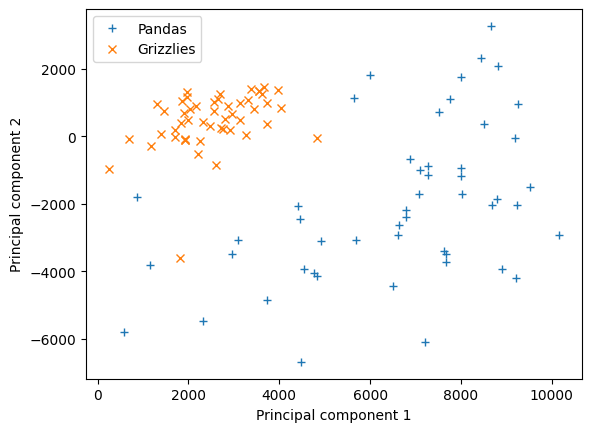

In [55]:
# Clustering of panda bears and brown bears along the first and second principal component
# indices of pandas in the test set
indices_pandas = range(50)
# indices of brown bears in the test set
indices_brownbears = range(50,100)

for i, indices in enumerate([indices_pandas, indices_brownbears]):
    # get projections of data onto principal component 1

    # changed to test_images[x] instead of test_images(x) because test_images is a list, not a function
    p1 = [np.dot(U[:,0],np.ravel(test_images[x])) for x in indices]
    # get projections of data onto principal component 2
    p2 = [np.dot(U[:,1],np.ravel(test_images[x])) for x in indices]
    plt.plot(p1, p2, marker='+x'[i], lw=0, label=['Pandas', 'Grizzlies'][i])

# annotate axes
plt.xlabel('Principal component 1')
plt.ylabel('Principal component 2')

# add legend
plt.legend()

# Besides a couple outliers that are more in "panda" regions, most of the grizzlies are clustered around 2200, 700 
# for principal components 1, 2
# on the other hand, the pandas are spread out tbetween 0 and 100000 for principal component 1 and -7000 and 3000 for 2

# Part 3: Nonparametric classification

In [56]:
from sklearn.neighbors import KNeighborsClassifier

In [57]:
# construct response variable: Train set was created by appending 250 pandas
# and THEN 250 brown bears to the list of training images. We code pandas as
# '0' and brown bears as '1'.
y_train =  np.concatenate([np.zeros(250), np.ones(250)])

# Test set was created by appending 50 pandas and THEN 50 brown bears to the 
# list of test images. We code pandas as '0' and brown bears as '1'.
y_test = np.concatenate([np.zeros(50), np.ones(50)])

In [58]:
print('   k\t|  # errors\t| misclassified bears')
print('--------------------------------------------')

# make a dictionary to count # errors for each bear (initial error = 0)
error_count = {}
for i in range (1,50):
    error_count[i] = 0

for k in range(1,16):
    # fit KNN model
    modelKN = KNeighborsClassifier(n_neighbors=k).fit(X.T, y_train)
    # use model to make predictions on the test set

    # changed from len(y_test) to range(len(y_test)) so we can iterate over the range (can't iterate over integer)
    predictions = [modelKN.predict([np.ravel(test_images[i])]) for i in range(len(y_test))]
    
    # detect misclassifications
    errors = np.abs((np.array(predictions).T)[0]-y_test)

    # increment # errors for each misclassified bear in this knn test
    for i in (np.argwhere(errors).T)[0]:
        error_count[i] = error_count[i] + 1

    # print results to table
    print('    {}\t|      {} \t| {}'.format(k, int(np.sum(errors)), (np.argwhere(errors).T)[0]))


# We get the best accuracy with 6-nearest neighbors (k = 6). This method had only 5 errors. If k > 5 we have between 6-8 errors.

   k	|  # errors	| misclassified bears
--------------------------------------------
    1	|      9 	| [ 5  6  8 21 22 24 39 41 42]
    2	|      6 	| [ 6  8 21 22 39 42]
    3	|      10 	| [ 5  6  8 21 22 32 36 39 41 42]
    4	|      7 	| [ 6  8 21 22 39 41 42]
    5	|      9 	| [ 5  6  8 21 22 32 39 41 42]
    6	|      7 	| [ 5 21 22 32 39 41 42]
    7	|      9 	| [ 5  9 21 22 24 32 39 41 42]
    8	|      6 	| [ 5 21 22 39 41 42]
    9	|      8 	| [ 5  6 21 22 32 39 41 42]
    10	|      6 	| [ 5 21 22 32 41 42]
    11	|      7 	| [ 5  6 21 22 32 41 42]
    12	|      6 	| [ 5 21 22 32 41 42]
    13	|      6 	| [ 5 21 22 32 41 42]
    14	|      5 	| [ 5 21 32 41 42]
    15	|      5 	| [ 5 21 32 41 42]


[5, 21, 22, 32, 41, 42]


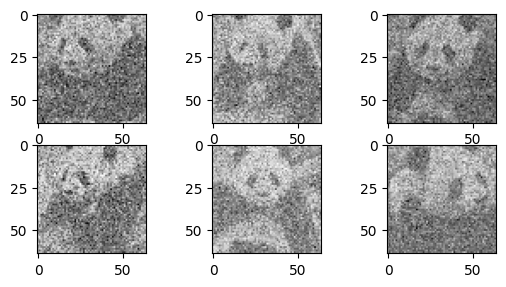

In [59]:
# Show hard-to-classify bears
'''ADD SOME CODE'''

# pick bears with most misclassifications
misclassified_is = []

for i in error_count:
    # pick only the bears with more than 10 misclassifications among all 16 iterations of the KNN model
    if error_count[i] > 10:
        misclassified_is.append(i)

print(misclassified_is)

# show the most misclassified bears

# number of bears in each row will be the number of misclassified bears / 2, rounded up
cols = int(len(misclassified_is)/2) + (len(misclassified_is) % 2 > 0)

# show misclassified bears
for i0, i in enumerate(misclassified_is):
    plt.subplot(cols,cols,1+i0)
    plt.imshow(train_images[i][::2,::2],cmap='Greys_r')


# bears 5, 21, 22, 32, 39, 41, 42 (all pandas) are most difficult to classify
# These bears could be hard to classify because there is a lot of their arms showing, thus more darker pixelation in the image
# The more frequent darker pixelation may get them confused with Grizzlies, which have a darker body overall

# Part 4: Parametric classification

In [60]:
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

In [61]:
# first fit a logistic reg. 
modelLogReg = LogisticRegression().fit(X.T, y_train)
predictions = [modelLogReg.predict([np.ravel(test_images[i])]) for i in range(len(y_test))]
    
# detect misclassifications
errors = np.abs((np.array(predictions).T)[0]-y_test)

# print results to table
print("LogReg Analysis:", int(np.sum(errors)), "errors in following indices \n", (np.argwhere(errors).T)[0])

modelLDA = LinearDiscriminantAnalysis().fit(X.T, y_train)
predictions = [modelLDA.predict([np.ravel(test_images[i])]) for i in range(len(y_test))]
    
# detect misclassifications
errors = np.abs((np.array(predictions).T)[0]-y_test)

# print results to table
print("LDA Analysis:", int(np.sum(errors)), "errors in following indices \n", (np.argwhere(errors).T)[0])


# Log Reg Analysis gives the best test accuracy as it made 35 errors vs. 46 using LDA. Both results are worse than non-parametric
# classification, which made 10 errors or fewer, depending on the value of k.
# Also, all of the errors were in misclassifying the Grizzlies as Pandas; this is the opposite result of 
# the non-parametric classification, where all of the errors were misclassifying Pandas as Grizzlies

LogReg Analysis: 41 errors in following indices 
 [50 51 53 55 56 57 58 59 60 61 63 65 66 67 68 69 70 71 72 73 74 75 76 78
 80 81 82 83 84 85 86 87 88 89 90 91 92 94 95 97 98]
LDA Analysis: 49 errors in following indices 
 [50 51 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74
 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98
 99]


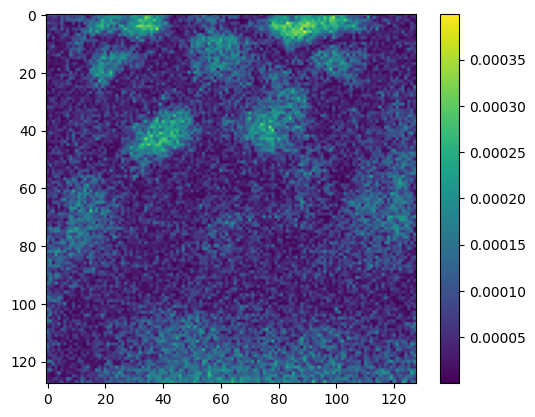

In [62]:
# Construct the bear mask:
# Show absolute value of logistic-regression coefficients for each pixel
plt.imshow(np.abs((modelLogReg.coef_).reshape((128,128))))
plt.colorbar()

# I see mostly low values ~0.0001. There are patches of greater values ~0.0002 in fur like patches
# the highest values are near the top ~0.0004, in patches where the eyes, ears, above the ears, and forehead typically are
# Thus I conclude that the top half, the upper part of the head of the bear in the images is what is most important in determining the
# classification of the bear.

In [53]:
# Part 5

# KNN Neighbors
# We get more errors than before when K <9, but as K gets bigger, we actually get fewer errors ~5-6 instead of 7 when we run the KNN model

# Log. Reg.
# Log regression makes more errors when there is noise. 41 errors as opposed to 35.

# LDA
# LDA makes more errors when there is noise. 49 errors as opposed to 46. 
# Again, the errors were all when i >= 50 (all Grizzlies). This means all but 1 Grizzly was misclassified.


# Eigenbear
# The eigenbears are even more blurry and more uniformly gray when we set add_noise = True It is hard to distinguish between the bears
# and the background

# Bear Mask
# The bear mask shows a simplified grouping of patches of higher consequence pixels. Also, the importance of individual pixels are smaller.
# They range from 0.00005 to 0.00030 instead of 0.0001 to 0.0005
# Still, the patches near the eyes, ears, above the ears, and forehead are most important in determining the classification

# Other Noise
# Based on the 4 random displayed bears, the noise is pretty regular across the regions of the image. Since the classifications
# are usually determined by the upper part of the bear head, more irregular noise, that could affect the important regions only, 
# might cause more misclassifications